<a href="https://colab.research.google.com/github/RicksonRick/Cotton-Price-Prediction---SARIMAX-approach/blob/main/cottonarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project was previously developed for a company in the cotton sector. Aiming to support future researchers, I opted to use an ARIMAX model instead of a simple linear regression due to its superior performance. Despite the greater complexity in configuration, the ARIMAX model is effective in managing various variables that influence the price of commodities.

In this notebook, we will focus on predicting the price of cotton. For demonstration purposes, we will use only historical data on cotton prices, Brent oil prices, and the Chinese interest rate. However, for production applications, other significant variables are considered, such as the American interest rate and the monsoon period, which were incorporated into the final model.

Observations in subsequent tests revealed that including data on the day's opening and closing can significantly improve the model's performance. As with any autoregressive or machine learning model, the input data are crucial, impacting more than the model's own weights!

Here is the basic formula of the SARIMAX model:
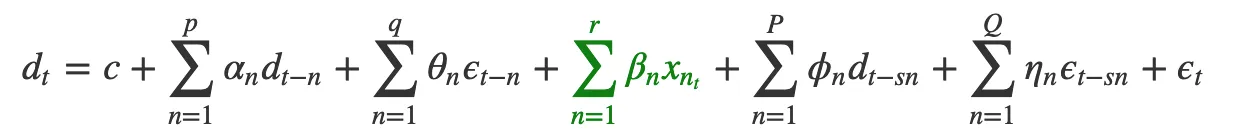

If you are new to the concept of ARIMAX models, I recommend reading this article: https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

I am open to discussions and questions! Don't hesitate to reach out.



In [ ]:
!pip install pandas==2.0.3 scikit-learn==1.3.0 numpy==1.24.4 statsmodels==0.14.0 arch==6.1.0 matplotlib==3.7.2 seaborn

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os

directory_path = '/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT'
csv_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.csv')]

print(f"Found {len(csv_files)} CSV files: {csv_files}")

Found 4 CSV files: ['/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT/BRENT_PREÇO.csv', '/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT/TAXA_JUROS_CHINA.csv', '/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT/ALGODAO_PREÇO.csv', '/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT/inflacao_eua_corrigida_inflacao.csv']


In this code, we will explore various approaches to handle and learn from datasets originating from different sources and with diverse structures. Our objective is to prepare, clean, and consolidate these datasets in one place for model training.

This notebook contains lines of code dedicated to data management and cleaning, providing visualizations of correlations for a better human understanding of the data. We also focus on searching for the optimal parameters, training the model with these parameters, and finally conducting a residual analysis.

By systematically addressing these elements, we aim to enhance both the performance of the model and our comprehension of the underlying data dynamics.

In [ ]:
import pandas as pd

def clean_data(df, value_column_name):
    # Remove currency symbols and convert to float
    df[value_column_name] = df[value_column_name].replace('[\$,]', '', regex=True).astype(float)
    return df

def prepare_combined_data():
    df1 = pd.read_csv('/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT/TAXA_JUROS_CHINA.csv', names=['date', 'interest_rate_china'], skiprows=1)
    df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m')

    df2 = pd.read_csv('/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT/BRENT_PREÇO.csv', names=['date', 'brent_price'])
    df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m')
    df2 = clean_data(df2, 'brent_price')

    df3 = pd.read_csv('/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT/ALGODAO_PREÇO.csv', names=['date', 'cotton_price'])
    df3['date'] = pd.to_datetime(df3['date'], format='%Y-%m')
    df3 = clean_data(df3, 'cotton_price')

    combined_df = pd.merge(pd.merge(df1, df2, on='date', how='outer'), df3, on='date', how='outer')
    combined_df = combined_df.sort_values('date')

    date_range = pd.date_range(start='2000-01-01', end='2023-05-01', freq='MS')
    combined_df = combined_df.set_index('date').reindex(date_range).reset_index()
    combined_df.rename(columns={'index': 'date'}, inplace=True)
    combined_df['date'] = combined_df['date'].dt.strftime('%Y-%m')  # Format date as string for consistency

    # Fill missing numeric values using a moving average
    for column in combined_df.columns[1:]:
        combined_df[column] = combined_df[column].fillna(combined_df[column].rolling(window=7, min_periods=1, center=True).mean())

    # Check for any missing dates after reindexing
    if combined_df.index.isnull().any():
        print("There are missing dates in the DataFrame.")
    else:
        print("No missing dates in the DataFrame after reindexing.")

    return combined_df

combined_df = prepare_combined_data()
print(combined_df)


Não há datas faltantes no DataFrame após a reindexação.
        date  interest_rate_china  brent_price  cotton_price
0    2000-01               0.0585        27.45          0.55
1    2000-02               0.0585        29.43          0.57
2    2000-03               0.0585        27.76          0.61
3    2000-04               0.0585        24.39          0.56
4    2000-05               0.0585        29.43          0.61
..       ...                  ...          ...           ...
276  2023-01               0.0365        85.17          0.84
277  2023-02               0.0365        82.83          0.85
278  2023-03               0.0365        79.89          0.81
279  2023-04               0.0365        80.33          0.81
280  2023-05               0.0365        72.60          0.82

[281 rows x 4 columns]


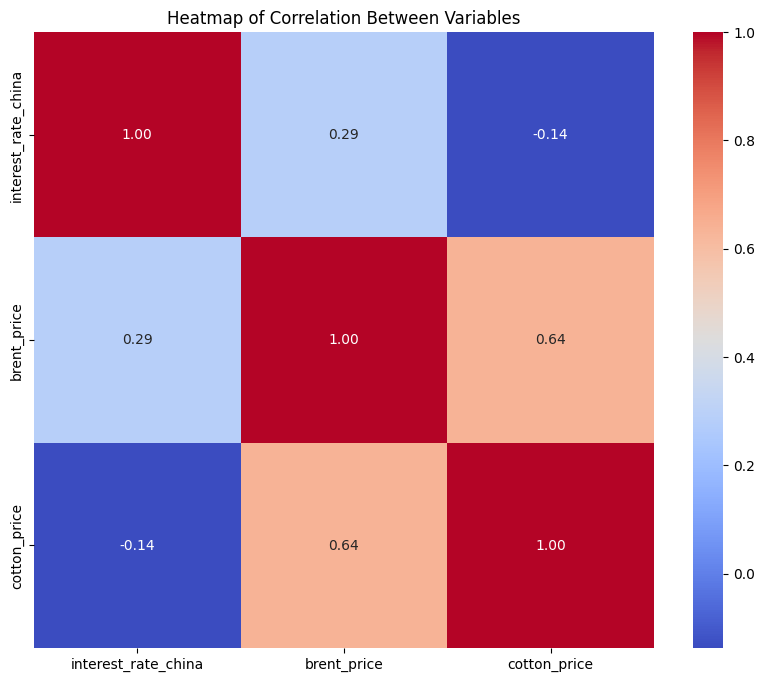

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = combined_df[['interest_rate_china', 'brent_price', 'cotton_price']].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Correlation Between Variables')
plt.show()


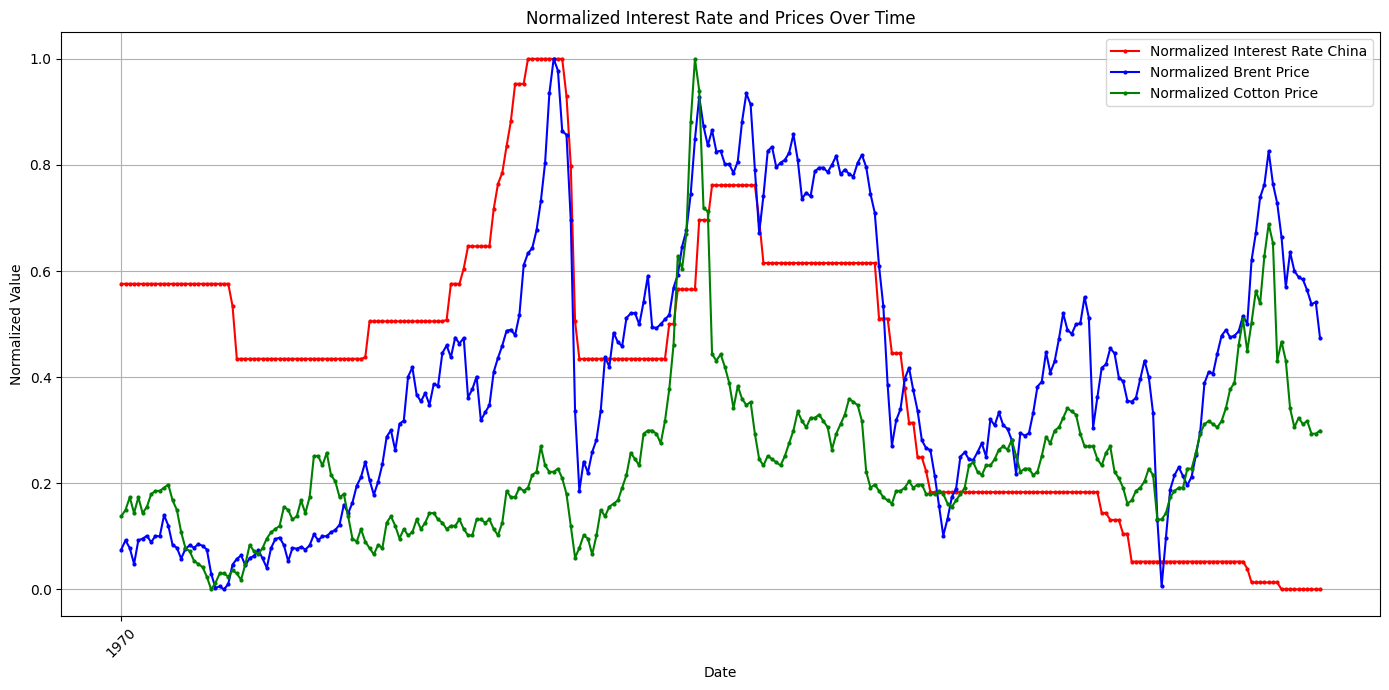

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Normalize the data
combined_df['norm_interest_rate_china'] = (combined_df['interest_rate_china'] - combined_df['interest_rate_china'].min()) / (combined_df['interest_rate_china'].max() - combined_df['interest_rate_china'].min())
combined_df['norm_brent_price'] = (combined_df['brent_price'] - combined_df['brent_price'].min()) / (combined_df['brent_price'].max() - combined_df['brent_price'].min())
combined_df['norm_cotton_price'] = (combined_df['cotton_price'] - combined_df['cotton_price'].min()) / (combined_df['cotton_price'].max() - combined_df['cotton_price'].min())

# Create the plot with normalized data
plt.figure(figsize=(14, 7))
plt.plot(combined_df['date'], combined_df['norm_interest_rate_china'], label='Normalized Interest Rate China', marker='o', linestyle='-', markersize=2, color='red')
plt.plot(combined_df['date'], combined_df['norm_brent_price'], label='Normalized Brent Price', marker='o', linestyle='-', markersize=2, color='blue')
plt.plot(combined_df['date'], combined_df['norm_cotton_price'], label='Normalized Cotton Price', marker='o', linestyle='-', markersize=2, color='green')

plt.title('Normalized Interest Rate and Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)

# Adjust the x-axis ticks
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set the major locator to annual
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Set the tick format to only show the year
plt.xticks(rotation=45)  # Rotate ticks for better readability

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

def clean_data(df, value_column_name):
    # Remove currency symbols and convert to float
    df[value_column_name] = df[value_column_name].replace('[\$,]', '', regex=True).astype(float)
    return df

def prepare_combined_data():
    # Read and process the data files
    df1 = pd.read_csv('/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT/TAXA_JUROS_CHINA.csv', names=['date', 'interest_rate_china'], skiprows=1)
    df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m')

    df2 = pd.read_csv('/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT/BRENT_PREÇO.csv', names=['date', 'brent_price'])
    df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m')
    df2 = clean_data(df2, 'brent_price')

    df3 = pd.read_csv('/content/gdrive/MyDrive/CSV ALGODAO CHINA BRENT/ALGODAO_PREÇO.csv', names=['date', 'cotton_price'])
    df3['date'] = pd.to_datetime(df3['date'], format='%Y-%m')
    df3 = clean_data(df3, 'cotton_price')

    # Combine all dataframes
    combined_df = pd.merge(pd.merge(df1, df2, on='date', how='outer'), df3, on='date', how='outer')

    # Sort by date
    combined_df = combined_df.sort_values('date')

    # Create a complete monthly date series from start to end of the period
    date_range = pd.date_range(start='2000-01-01', end='2023-05-01', freq='MS')

    # Reindex the DataFrame to include all dates and keep 'date' as a column
    combined_df = combined_df.set_index('date').reindex(date_range).reset_index()
    combined_df.rename(columns={'index': 'date'}, inplace=True)
    combined_df['date'] = combined_df['date'].dt.strftime('%Y-%m')  # Formatting date as string for consistency

    # Fill missing numeric values using moving average
    for column in combined_df.columns[1:]:  # Skip 'date' column in iteration
        combined_df[column] = combined_df[column].fillna(combined_df[column].rolling(window=7, min_periods=1, center=True).mean())

    # Check for any missing dates after reindexing
    if combined_df.index.isnull().any():
        print("There are missing dates in the DataFrame.")
    else:
        print("No missing dates in the DataFrame after reindexing.")

    return combined_df

# Using the function
combined_df = prepare_combined_data()
print(combined_df.head[0])

Não há datas faltantes no DataFrame após a reindexação.
        date  interest_rate_china  brent_price  cotton_price
0    2000-01               0.0585        27.45          0.55
1    2000-02               0.0585        29.43          0.57
2    2000-03               0.0585        27.76          0.61
3    2000-04               0.0585        24.39          0.56
4    2000-05               0.0585        29.43          0.61
..       ...                  ...          ...           ...
276  2023-01               0.0365        85.17          0.84
277  2023-02               0.0365        82.83          0.85
278  2023-03               0.0365        79.89          0.81
279  2023-04               0.0365        80.33          0.81
280  2023-05               0.0365        72.60          0.82

[281 rows x 4 columns]


In [ ]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def preprocess_data(df):
    print("Starting preprocessing...")
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.dropna(subset=['date'], inplace=True)
    for column in ['interest_rate_china', 'brent_price', 'cotton_price']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df.dropna(inplace=True)
    if not df.index.equals(pd.DatetimeIndex(df['date'])):
        df.set_index('date', inplace=True)
        df.index = pd.DatetimeIndex(df.index, freq='MS')
    print("Preprocessing completed.")
    return df

def train_model(df):
    print("Starting training...")
    df.dropna(inplace=True)
    exog = df[['brent_price', 'interest_rate_china']]
    y = df['cotton_price']
    train_size = int(len(y) * 0.80)
    val_size = int(len(y) * 0.20)
    y_train, exog_train = y.iloc[:train_size], exog.iloc[:train_size]
    y_val, exog_val = y.iloc[train_size:train_size+val_size], exog.iloc[train_size:train_size+val_size]
    return y_train, exog_train, y_val, exog_val

def optimize_sarimax(y_train, exog_train, y_val, exog_val, p, d, q, seasonal_period):
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in pdq]
    best_rmse = float('inf')
    best_metrics = {}
    best_model = None
    best_params = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(y_train,
                                exog=exog_train,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=0, maxiter=500, method='lbfgs')

                y_pred = model.predict(start=y_val.index[0], end=y_val.index[-1], exog=exog_val)
                mae = mean_absolute_error(y_val, y_pred)
                mse = mean_squared_error(y_val, y_pred)
                rmse = np.sqrt(mse)
                r_squared = r2_score(y_val, y_pred)

                print(f"Testing parameters: {param}, {param_seasonal}")
                print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R^2: {r_squared}")

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R^2': r_squared}
                    best_model = model
                    best_params = (param, param_seasonal)
            except Exception as e:
                print(f"Error with parameters {param}, {param_seasonal}: {e}")
                continue

    return best_model, best_params, best_metrics

df = combined_df.copy()
processed_df = preprocess_data(df)
y_train, exog_train, y_val, exog_val = train_model(processed_df)
p = d = q = range(0, 3)
seasonal_period = 20
best_model, best_params, best_metrics = optimize_sarimax(y_train, exog_train, y_val, exog_val, p, d, q, seasonal_period)

if best_model is not None:
    print("Best model found:")
    print(f"Best model parameters: {best_params}")
    print(f"Best metrics: MAE: {best_metrics['MAE']}, MSE: {best_metrics['MSE']}, RMSE: {best_metrics['RMSE']}, R^2: {best_metrics['R^2']}")
    print(f"Model summary:\n{best_model.summary()}")
else:
    print("No valid model was found.")


Starting preprocessing...
Preprocessing completed.
Starting training...
Testing parameters: (0, 0, 0), (0, 0, 0, 20)
MAE: 0.2578563439331531, MSE: 0.09069684131063879, RMSE: 0.3011591627539146, R^2: -0.8476673607805978
Testing parameters: (0, 0, 0), (0, 0, 1, 20)
MAE: 0.2667574826301334, MSE: 0.09072403786702253, RMSE: 0.3012043124973853, R^2: -0.8482214064213247
Testing parameters: (0, 0, 0), (0, 0, 2, 20)
MAE: 0.2953347853618353, MSE: 0.10916198636374783, RMSE: 0.3303967105825175, R^2: -1.223837526507272
Testing parameters: (0, 0, 0), (0, 1, 0, 20)
MAE: 0.10598821713856924, MSE: 0.014797588001879485, RMSE: 0.12164533695082391, R^2: 0.6985449551025964
Testing parameters: (0, 0, 0), (0, 1, 1, 20)
MAE: 0.10531214005573188, MSE: 0.01946555358356653, RMSE: 0.1395190079651032, R^2: 0.6034496075480982
Testing parameters: (0, 0, 0), (0, 1, 2, 20)
MAE: 0.10480744410664873, MSE: 0.02045696530635399, RMSE: 0.14302784800993823, R^2: 0.5832526629266674
Testing parameters: (0, 0, 0), (0, 2, 0, 20)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (0, 0, 0), (1, 1, 0, 20)
MAE: 0.13440064325505835, MSE: 0.02577334600524573, RMSE: 0.16054079234028257, R^2: 0.474947864734385
Testing parameters: (0, 0, 0), (1, 1, 1, 20)
MAE: 0.10410089487681264, MSE: 0.019820686758413534, RMSE: 0.14078596080012215, R^2: 0.5962148685383039
Testing parameters: (0, 0, 0), (1, 1, 2, 20)
MAE: 0.10503288490135107, MSE: 0.02010610028811178, RMSE: 0.14179598121283896, R^2: 0.5904004514590756
Testing parameters: (0, 0, 0), (1, 2, 0, 20)
MAE: 0.14514406118607678, MSE: 0.031197881095523048, RMSE: 0.1766292192575256, R^2: 0.3644397556439446
Testing parameters: (0, 0, 0), (1, 2, 1, 20)
MAE: 0.12145073238307172, MSE: 0.021160074957514024, RMSE: 0.14546503001585648, R^2: 0.5689289804838717
Testing parameters: (0, 0, 0), (1, 2, 2, 20)
MAE: 0.11663825589783548, MSE: 0.02720599501232951, RMSE: 0.16494239907412983, R^2: 0.44576207643579147


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (0, 0, 0), (2, 0, 0, 20)
MAE: 0.29238851351985923, MSE: 0.10505096037909122, RMSE: 0.32411565895385436, R^2: -1.1400880990585796
Testing parameters: (0, 0, 0), (2, 0, 1, 20)
MAE: 0.2945554578772366, MSE: 0.10612858194766249, RMSE: 0.3257738202306356, R^2: -1.1620413023978537
Testing parameters: (0, 0, 0), (2, 0, 2, 20)
MAE: 0.2914252425061233, MSE: 0.10274732069297014, RMSE: 0.3205422291882462, R^2: -1.0931585721033175
Testing parameters: (0, 0, 0), (2, 1, 0, 20)
MAE: 0.12882828177176017, MSE: 0.02347338227504086, RMSE: 0.15321025512360736, R^2: 0.5218025054679456
Testing parameters: (0, 0, 0), (2, 1, 1, 20)
MAE: 0.09995500117740067, MSE: 0.01862775045135871, RMSE: 0.13648351714166335, R^2: 0.6205172526807248
Testing parameters: (0, 0, 0), (2, 1, 2, 20)
MAE: 0.10448756082940212, MSE: 0.019609894043965823, RMSE: 0.140035331413061, R^2: 0.6005091175192736
Testing parameters: (0, 0, 0), (2, 2, 0, 20)
MAE: 0.21982504882198434, MSE: 0.06843363013355616, RMSE: 0.261598222

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (0, 0, 2), (0, 0, 1, 20)
MAE: 0.2736156607158939, MSE: 0.09805197926873112, RMSE: 0.31313252668595626, R^2: -0.9975055265074515
Testing parameters: (0, 0, 2), (0, 0, 2, 20)
MAE: 0.2938196612377017, MSE: 0.10943282003386794, RMSE: 0.33080631800778526, R^2: -1.2293549240841894
Testing parameters: (0, 0, 2), (0, 1, 0, 20)
MAE: 0.12132301597196112, MSE: 0.02191909142919043, RMSE: 0.14805097577925797, R^2: 0.5534663696504023
Testing parameters: (0, 0, 2), (0, 1, 1, 20)
MAE: 0.10966154411384539, MSE: 0.02165899494937474, RMSE: 0.14716995260369808, R^2: 0.5587650302152549
Testing parameters: (0, 0, 2), (0, 1, 2, 20)
MAE: 0.10646074490621496, MSE: 0.021175818201797536, RMSE: 0.1455191334560426, R^2: 0.568608260619816
Testing parameters: (0, 0, 2), (0, 2, 0, 20)
MAE: 0.18935424811729082, MSE: 0.05300868364900789, RMSE: 0.23023614757246066, R^2: -0.07988782410581408
Testing parameters: (0, 0, 2), (0, 2, 1, 20)
MAE: 0.14132731747273197, MSE: 0.032135520356916324, RMSE: 0.17926

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (0, 1, 1), (1, 1, 1, 20)
MAE: 0.1677430633225887, MSE: 0.03679487932490793, RMSE: 0.19181991378610286, R^2: 0.2504182440086966
Testing parameters: (0, 1, 1), (1, 1, 2, 20)
MAE: 0.17063498830937235, MSE: 0.037247620058957466, RMSE: 0.19299642499009526, R^2: 0.24119505315540002
Testing parameters: (0, 1, 1), (1, 2, 0, 20)
MAE: 0.5077461499940394, MSE: 0.3326529619365345, RMSE: 0.5767607493029796, R^2: -5.776774266393648
Testing parameters: (0, 1, 1), (1, 2, 1, 20)
MAE: 0.19520699143198386, MSE: 0.04995686402592779, RMSE: 0.22351032196730378, R^2: -0.017716447164008553
Testing parameters: (0, 1, 1), (1, 2, 2, 20)
MAE: 0.15622060771565388, MSE: 0.031792762245460175, RMSE: 0.1783052501903973, R^2: 0.35232089385781173
Testing parameters: (0, 1, 1), (2, 0, 0, 20)
MAE: 0.14321423453411505, MSE: 0.033494094270479606, RMSE: 0.18301391824251947, R^2: 0.3176615208625315
Testing parameters: (0, 1, 1), (2, 0, 1, 20)
MAE: 0.14310378875950167, MSE: 0.033391960318819865, RMSE: 0.182

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (0, 2, 0), (0, 0, 1, 20)
MAE: 0.354586855635621, MSE: 0.22824133929763096, RMSE: 0.4777461033829904, R^2: -3.6497106945180393
Testing parameters: (0, 2, 0), (0, 0, 2, 20)
MAE: 0.36315263223110666, MSE: 0.2384308947841323, RMSE: 0.4882938610960948, R^2: -3.8572913425451167
Testing parameters: (0, 2, 0), (0, 1, 0, 20)
MAE: 0.25338344671742535, MSE: 0.09181409525984918, RMSE: 0.3030084079028983, R^2: -0.8704279511807522
Testing parameters: (0, 2, 0), (0, 1, 1, 20)
MAE: 0.22856595651147346, MSE: 0.08380001406393224, RMSE: 0.28948232081412545, R^2: -0.7071658569516299
Testing parameters: (0, 2, 0), (0, 1, 2, 20)
MAE: 0.21202271365834585, MSE: 0.0808884033741356, RMSE: 0.2844088665533049, R^2: -0.6478508029641201
Testing parameters: (0, 2, 0), (0, 2, 0, 20)
MAE: 0.27325744701066795, MSE: 0.10134248645426748, RMSE: 0.31834334680383614, R^2: -1.0645394236010253
Testing parameters: (0, 2, 0), (0, 2, 1, 20)
MAE: 0.25744070704639427, MSE: 0.09914608917235321, RMSE: 0.314874719

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (0, 2, 0), (2, 1, 2, 20)
MAE: 0.26470496283967665, MSE: 0.12217336577928069, RMSE: 0.3495330682199907, R^2: -1.4889041012347493
Testing parameters: (0, 2, 0), (2, 2, 0, 20)
MAE: 1.7413730850638356, MSE: 5.276433425472925, RMSE: 2.2970488513466414, R^2: -106.49099616586663
Testing parameters: (0, 2, 0), (2, 2, 1, 20)
MAE: 0.5179426153596621, MSE: 0.4751911829122884, RMSE: 0.6893411223133931, R^2: -8.680549246369056
Testing parameters: (0, 2, 0), (2, 2, 2, 20)
MAE: 0.6823360260042736, MSE: 0.80475072336115, RMSE: 0.8970789950506868, R^2: -15.39430462662163


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (0, 2, 1), (0, 0, 0, 20)
MAE: 0.14719298044757803, MSE: 0.030244945164402032, RMSE: 0.1739107390715192, R^2: 0.38385287512422395
Testing parameters: (0, 2, 1), (0, 0, 1, 20)
MAE: 0.1513007848956527, MSE: 0.03073133371055405, RMSE: 0.17530354734161557, R^2: 0.3739442142668453
Testing parameters: (0, 2, 1), (0, 0, 2, 20)
MAE: 0.14536825960585684, MSE: 0.030587251810891034, RMSE: 0.17489211477619862, R^2: 0.37687943692112513
Testing parameters: (0, 2, 1), (0, 1, 0, 20)
MAE: 0.22306442176950517, MSE: 0.06459874198032114, RMSE: 0.25416282572461524, R^2: -0.3159993818938669
Testing parameters: (0, 2, 1), (0, 1, 1, 20)
MAE: 0.19215230493644792, MSE: 0.04328292454189025, RMSE: 0.20804548671357964, R^2: 0.11824440852055007
Testing parameters: (0, 2, 1), (0, 1, 2, 20)
MAE: 0.16276177690543964, MSE: 0.034869999962336265, RMSE: 0.18673510640031313, R^2: 0.2896317019447079
Testing parameters: (0, 2, 1), (0, 2, 0, 20)
MAE: 0.16054631067445718, MSE: 0.040133034317283954, RMSE: 0.2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 0, 1), (2, 2, 1, 20)
MAE: 0.12626974820656361, MSE: 0.02694501682058161, RMSE: 0.16414937350042372, R^2: 0.4510786991516432
Testing parameters: (1, 0, 1), (2, 2, 2, 20)
MAE: 0.12847839588730856, MSE: 0.02663837298133855, RMSE: 0.16321266182909508, R^2: 0.45732561806267025
Testing parameters: (1, 0, 2), (0, 0, 0, 20)
MAE: 0.27834486668504527, MSE: 0.14052007238212452, RMSE: 0.374860070402443, R^2: -1.8626614502011694


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 0, 2), (0, 0, 1, 20)
MAE: 0.26514397178991655, MSE: 0.12839608832751032, RMSE: 0.3583239990951071, R^2: -1.615672808737782
Testing parameters: (1, 0, 2), (0, 0, 2, 20)
MAE: 0.17669470211419094, MSE: 0.0545730094984299, RMSE: 0.23360866743002046, R^2: -0.11175612041949612
Testing parameters: (1, 0, 2), (0, 1, 0, 20)
MAE: 0.14334881218349366, MSE: 0.029162541226840897, RMSE: 0.17077043428779146, R^2: 0.40590350442632195
Testing parameters: (1, 0, 2), (0, 1, 1, 20)
MAE: 0.13546751797041875, MSE: 0.031837062500076244, RMSE: 0.17842943283011423, R^2: 0.3514184133155397
Testing parameters: (1, 0, 2), (0, 1, 2, 20)
MAE: 0.13854514469073512, MSE: 0.03229865083911217, RMSE: 0.17971825405092318, R^2: 0.3420149799012212
Testing parameters: (1, 0, 2), (0, 2, 0, 20)
MAE: 0.18204349984814172, MSE: 0.05078382398717053, RMSE: 0.22535266580888394, R^2: -0.034563196256706785
Testing parameters: (1, 0, 2), (0, 2, 1, 20)
MAE: 0.14904887410394688, MSE: 0.031840007878261876, RMSE: 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 0, 2), (2, 1, 0, 20)
MAE: 0.12464559333171296, MSE: 0.025668225026688397, RMSE: 0.16021306134859417, R^2: 0.47708937923706163
Testing parameters: (1, 0, 2), (2, 1, 1, 20)
MAE: 0.1388232815407501, MSE: 0.03263969067885545, RMSE: 0.18066458058749493, R^2: 0.33506734896376333
Testing parameters: (1, 0, 2), (2, 1, 2, 20)
MAE: 0.1380270922659534, MSE: 0.03213239348020177, RMSE: 0.17925510726392643, R^2: 0.3454019588864782
Testing parameters: (1, 0, 2), (2, 2, 0, 20)
MAE: 0.1495440460240423, MSE: 0.028827028086517794, RMSE: 0.16978524107388662, R^2: 0.41273854597274995
Testing parameters: (1, 0, 2), (2, 2, 1, 20)
MAE: 0.12765895292395174, MSE: 0.027978859708264137, RMSE: 0.16726882467532359, R^2: 0.4300173509046442
Testing parameters: (1, 0, 2), (2, 2, 2, 20)
MAE: 0.12925199298682236, MSE: 0.027447064213503132, RMSE: 0.16567155523354976, R^2: 0.44085103776827717


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 1, 0), (0, 0, 0, 20)
MAE: 0.1487092589940417, MSE: 0.03369228581779223, RMSE: 0.1835545853902654, R^2: 0.3136239816510178
Testing parameters: (1, 1, 0), (0, 0, 1, 20)
MAE: 0.14512011362053512, MSE: 0.034318203624034094, RMSE: 0.1852517304211599, R^2: 0.3008728440765186
Testing parameters: (1, 1, 0), (0, 0, 2, 20)
MAE: 0.14441304006825564, MSE: 0.034697797051113984, RMSE: 0.18627344698349785, R^2: 0.29313980315197097
Testing parameters: (1, 1, 0), (0, 1, 0, 20)
MAE: 0.20071991147548093, MSE: 0.052416469757377966, RMSE: 0.22894643425346892, R^2: -0.06782329945034382
Testing parameters: (1, 1, 0), (0, 1, 1, 20)
MAE: 0.1665983482874122, MSE: 0.03657487068784355, RMSE: 0.1912455769105355, R^2: 0.25490023888216073
Testing parameters: (1, 1, 0), (0, 1, 2, 20)
MAE: 0.1708687299142254, MSE: 0.037693633304259025, RMSE: 0.19414848262157247, R^2: 0.23210891405826184
Testing parameters: (1, 1, 0), (0, 2, 0, 20)
MAE: 0.23857687179918027, MSE: 0.07957003111821592, RMSE: 0.2820

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 1, 1), (0, 0, 1, 20)
MAE: 0.14477688084991555, MSE: 0.034274236082147434, RMSE: 0.1851330226678845, R^2: 0.30176854662694685
Testing parameters: (1, 1, 1), (0, 0, 2, 20)
MAE: 0.1440682012326245, MSE: 0.03475840535716667, RMSE: 0.18643606238377453, R^2: 0.2919050965484389
Testing parameters: (1, 1, 1), (0, 1, 0, 20)
MAE: 0.1947973646605676, MSE: 0.04962883419376451, RMSE: 0.22277529978380572, R^2: -0.011033854854376024
Testing parameters: (1, 1, 1), (0, 1, 1, 20)
MAE: 0.16514112209705042, MSE: 0.0363202529258922, RMSE: 0.1905787315675393, R^2: 0.26008728753164145
Testing parameters: (1, 1, 1), (0, 1, 2, 20)
MAE: 0.17045477846955356, MSE: 0.03755161563954209, RMSE: 0.19378239249101578, R^2: 0.23500208431601133
Testing parameters: (1, 1, 1), (0, 2, 0, 20)
MAE: 0.2140355752599628, MSE: 0.06709541678130396, RMSE: 0.25902783012893416, R^2: -0.3668614017128331
Testing parameters: (1, 1, 1), (0, 2, 1, 20)
MAE: 0.22802376627756546, MSE: 0.06872562929166297, RMSE: 0.26215

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 1, 1), (1, 0, 2, 20)
MAE: 0.14365054513733447, MSE: 0.03439405645614228, RMSE: 0.1854563464973423, R^2: 0.2993275774488854
Testing parameters: (1, 1, 1), (1, 1, 0, 20)
MAE: 0.18658348637766756, MSE: 0.044738414291848015, RMSE: 0.21151457229195347, R^2: 0.08859331079668442
Testing parameters: (1, 1, 1), (1, 1, 1, 20)
MAE: 0.16694841694993381, MSE: 0.036749544133646936, RMSE: 0.19170170613128862, R^2: 0.2513418081811333


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 1, 1), (1, 1, 2, 20)
MAE: 0.17005681019222132, MSE: 0.037294821536281754, RMSE: 0.1931186721585506, R^2: 0.24023346918210586
Testing parameters: (1, 1, 1), (1, 2, 0, 20)
MAE: 0.4936723077831597, MSE: 0.315441041940217, RMSE: 0.5616413819691503, R^2: -5.426134681442277
Testing parameters: (1, 1, 1), (1, 2, 1, 20)
MAE: 0.1932149149239055, MSE: 0.04910767111725256, RMSE: 0.22160250701933082, R^2: -0.0004167705965345547
Testing parameters: (1, 1, 1), (1, 2, 2, 20)
MAE: 0.15738210204568087, MSE: 0.03229205648856446, RMSE: 0.1796999067572503, R^2: 0.34214931937872095
Testing parameters: (1, 1, 1), (2, 0, 0, 20)
MAE: 0.1436707112385071, MSE: 0.034115404997643844, RMSE: 0.18470355978606326, R^2: 0.30500423826156
Testing parameters: (1, 1, 1), (2, 0, 1, 20)
MAE: 0.14367172468691822, MSE: 0.0340299565101598, RMSE: 0.1844721022544054, R^2: 0.3067449866610725
Testing parameters: (1, 1, 1), (2, 0, 2, 20)
MAE: 0.14370996416926246, MSE: 0.03449034305708517, RMSE: 0.18571575877

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 1, 2), (1, 1, 0, 20)
MAE: 0.18567537693169936, MSE: 0.04431247484230706, RMSE: 0.21050528459472712, R^2: 0.0972705084500205
Testing parameters: (1, 1, 2), (1, 1, 1, 20)
MAE: 0.16693748927924035, MSE: 0.0367636404309644, RMSE: 0.191738468834411, R^2: 0.25105463976286235
Testing parameters: (1, 1, 2), (1, 1, 2, 20)
MAE: 0.16843910002900417, MSE: 0.03695084337059233, RMSE: 0.19222602157510396, R^2: 0.24724095941419377
Testing parameters: (1, 1, 2), (1, 2, 0, 20)
MAE: 0.48663200216428365, MSE: 0.3069465274479685, RMSE: 0.5540275511632688, R^2: -5.253085246134499
Testing parameters: (1, 1, 2), (1, 2, 1, 20)
MAE: 0.1922626632387752, MSE: 0.04864776693633899, RMSE: 0.22056238785508964, R^2: 0.008952353309888306
Testing parameters: (1, 1, 2), (1, 2, 2, 20)
MAE: 0.15705245975034648, MSE: 0.03223295775044774, RMSE: 0.17953539414401756, R^2: 0.3433532732089055
Testing parameters: (1, 1, 2), (2, 0, 0, 20)
MAE: 0.14303314713679602, MSE: 0.033993510737152934, RMSE: 0.18437329

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 2, 0), (2, 1, 1, 20)
MAE: 0.41135499528491615, MSE: 0.28743887322144523, RMSE: 0.5361332606931277, R^2: -4.855677183418285
Testing parameters: (1, 2, 0), (2, 1, 2, 20)
MAE: 0.46733443919246376, MSE: 0.35928013627337324, RMSE: 0.5993998133744899, R^2: -6.319220510618262
Testing parameters: (1, 2, 0), (2, 2, 0, 20)
MAE: 1.6261942214630805, MSE: 4.603627263448201, RMSE: 2.145606502471551, R^2: -92.78465350011244
Testing parameters: (1, 2, 0), (2, 2, 1, 20)
MAE: 0.31452248810038075, MSE: 0.18230101122932954, RMSE: 0.4269672250060062, R^2: -2.7138187330259194
Testing parameters: (1, 2, 0), (2, 2, 2, 20)
MAE: 0.5039668211499463, MSE: 0.4589520339720224, RMSE: 0.6774599869896542, R^2: -8.349726860162484
Testing parameters: (1, 2, 1), (0, 0, 0, 20)
MAE: 0.1531939729066641, MSE: 0.03342512340145289, RMSE: 0.18282539047258423, R^2: 0.31906658879768546
Testing parameters: (1, 2, 1), (0, 0, 1, 20)
MAE: 0.15724091179835092, MSE: 0.03309782983903322, RMSE: 0.18192808974711194

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 2, 1), (0, 2, 1, 20)
MAE: 0.18839264220227278, MSE: 0.048211076990491444, RMSE: 0.2195702097063521, R^2: 0.017848559043889933
Testing parameters: (1, 2, 1), (0, 2, 2, 20)
MAE: 0.15711093200626083, MSE: 0.04368646811098572, RMSE: 0.20901308119585654, R^2: 0.11002345759771837
Testing parameters: (1, 2, 1), (1, 0, 0, 20)
MAE: 0.15776084034505988, MSE: 0.033082899733500794, RMSE: 0.1818870521326375, R^2: 0.3260383365699814


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 2, 1), (1, 0, 1, 20)
MAE: 0.157663383804351, MSE: 0.03306828150976678, RMSE: 0.18184686279880327, R^2: 0.32633613762320013
Testing parameters: (1, 2, 1), (1, 0, 2, 20)
MAE: 0.15149669315802022, MSE: 0.03270799694800638, RMSE: 0.18085352346030303, R^2: 0.333675820193598
Testing parameters: (1, 2, 1), (1, 1, 0, 20)
MAE: 0.19922607640927964, MSE: 0.05090184313385598, RMSE: 0.22561436819018416, R^2: -0.036967471004611285
Testing parameters: (1, 2, 1), (1, 1, 1, 20)
MAE: 0.16524296881035644, MSE: 0.036809151674835235, RMSE: 0.19185711265114785, R^2: 0.250127489063527
Testing parameters: (1, 2, 1), (1, 1, 2, 20)
MAE: 0.1675544546394632, MSE: 0.03703838608929195, RMSE: 0.19245359463853084, R^2: 0.24545754753702276
Testing parameters: (1, 2, 1), (1, 2, 0, 20)
MAE: 0.584027137200591, MSE: 0.44466058296798217, RMSE: 0.6668287508558567, R^2: -8.058582789687971
Testing parameters: (1, 2, 1), (1, 2, 1, 20)
MAE: 0.2758068632574577, MSE: 0.09854200927381117, RMSE: 0.3139140157

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 2, 2), (0, 1, 0, 20)
MAE: 0.22157274653545192, MSE: 0.06394122402762772, RMSE: 0.25286601991494967, R^2: -0.3026044891637225
Testing parameters: (1, 2, 2), (0, 1, 1, 20)
MAE: 0.19798620626116378, MSE: 0.046180556675717854, RMSE: 0.21489661857674228, R^2: 0.05921412433584283
Testing parameters: (1, 2, 2), (0, 1, 2, 20)
MAE: 0.16050518759391488, MSE: 0.03809257036338994, RMSE: 0.19517318044083296, R^2: 0.22398180651504096
Testing parameters: (1, 2, 2), (0, 2, 0, 20)
MAE: 0.1811032783213434, MSE: 0.05045593264938795, RMSE: 0.22462398057506672, R^2: -0.027883425341327595
Testing parameters: (1, 2, 2), (0, 2, 1, 20)
MAE: 0.18410545748156287, MSE: 0.046188763848322774, RMSE: 0.21491571335833676, R^2: 0.05904692860193106


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 2, 2), (0, 2, 2, 20)
MAE: 0.15909890242219854, MSE: 0.04492410229482908, RMSE: 0.21195306625484114, R^2: 0.0848104925922274
Testing parameters: (1, 2, 2), (1, 0, 0, 20)
MAE: 0.15556317416654325, MSE: 0.03214641266387348, RMSE: 0.17929420700031967, R^2: 0.3451163614200097
Testing parameters: (1, 2, 2), (1, 0, 1, 20)
MAE: 0.15559841734070692, MSE: 0.03216940906312985, RMSE: 0.179358325881822, R^2: 0.3446478809778305


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (1, 2, 2), (1, 0, 2, 20)
MAE: 0.15152525582739024, MSE: 0.03251655271583642, RMSE: 0.18032346690277565, R^2: 0.3375759037475402
Testing parameters: (1, 2, 2), (1, 1, 0, 20)
MAE: 0.1968712427531812, MSE: 0.049603237317016005, RMSE: 0.22271784238586725, R^2: -0.010512397733899892
Testing parameters: (1, 2, 2), (1, 1, 1, 20)
MAE: 0.1639725752563424, MSE: 0.03660172048628193, RMSE: 0.19131576120717794, R^2: 0.25435325736107095
Testing parameters: (1, 2, 2), (1, 1, 2, 20)
MAE: 0.16653969507373936, MSE: 0.036976628565035856, RMSE: 0.19229307986777855, R^2: 0.24671566590367877
Testing parameters: (1, 2, 2), (1, 2, 0, 20)
MAE: 0.5696520116028182, MSE: 0.42333182933141517, RMSE: 0.6506395540784584, R^2: -7.6240754642846476
Testing parameters: (1, 2, 2), (1, 2, 1, 20)
MAE: 0.2715391145785779, MSE: 0.0956275229609804, RMSE: 0.3092370012805395, R^2: -0.9481147349127701
Testing parameters: (1, 2, 2), (1, 2, 2, 20)
MAE: 0.19000820906894414, MSE: 0.04522666547337929, RMSE: 0.21266

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing parameters: (2, 0, 0), (1, 1, 1, 20)
MAE: 0.13909900509516068, MSE: 0.03982391991061635, RMSE: 0.19955931426675216, R^2: 0.18871091943358254


KeyboardInterrupt: 

Starting preprocessing...
Preprocessing completed.
Starting training...


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Model training completed.
Evaluating model...
MAE: 0.10112897247560172
MSE: 0.015158362813968118
RMSE: 0.12311930317366208
Plotting predictions...


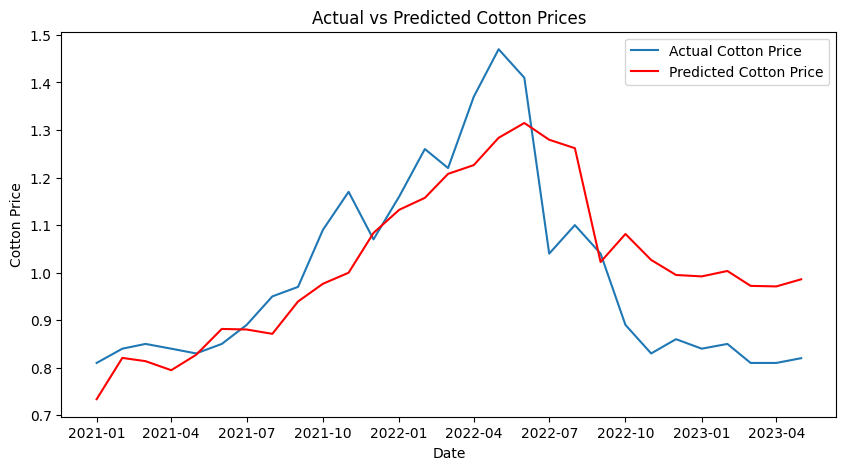

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def preprocess_data(df):
    print("Starting preprocessing...")
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.dropna(subset=['date'], inplace=True)
    for column in ['interest_rate_china', 'brent_price', 'cotton_price']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df.dropna(inplace=True)
    if not df.index.equals(pd.DatetimeIndex(df['date'])):
        df.set_index('date', inplace=True)
        df.index = pd.DatetimeIndex(df.index, freq='MS')
    print("Preprocessing completed.")
    return df

def train_model(df):
    print("Starting training...")
    df.dropna(inplace=True)
    exog = df[['brent_price', 'interest_rate_china']]
    y = df['cotton_price']

    train_size = int(len(y) * 0.90)
    y_train, exog_train = y.iloc[:train_size], exog.iloc[:train_size]

    model_fit = SARIMAX(y_train, exog=exog_train, order=(0, 0, 0), seasonal_order=(0, 1, 0, 20)).fit(disp=0)
    sarima_resid = model_fit.resid
    garch_model_fit = arch_model(sarima_resid, vol='Garch', p=1, q=1).fit(disp=0)

    print("Model training completed.")
    return y_train, exog_train, model_fit, garch_model_fit

def evaluate_model(df, y_train, exog_train, model_fit, garch_model_fit):
    print("Evaluating model...")
    y_test = df['cotton_price'].iloc[len(y_train):]
    exog_test = df[['brent_price', 'interest_rate_china']].iloc[len(y_train):]

    prediction_results = model_fit.get_forecast(steps=len(y_test), exog=exog_test)
    sarima_pred = prediction_results.predicted_mean
    garch_variance = garch_model_fit.forecast(horizon=len(y_test)).variance.values[-1]
    y_pred = sarima_pred + np.sqrt(garch_variance)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    return mae, mse, rmse, y_test, y_pred

def plot_predictions(y_test, y_pred):
    print("Plotting predictions...")
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index, y_test, label='Actual Cotton Price')
    plt.plot(y_test.index, y_pred, label='Predicted Cotton Price', color='red')
    plt.title('Actual vs Predicted Cotton Prices')
    plt.xlabel('Date')
    plt.ylabel('Cotton Price')
    plt.legend()
    plt.show()

df = combined_df.copy()
processed_df = preprocess_data(df)
y_train, exog_train, model_fit, garch_model_fit = train_model(processed_df)
mae, mse, rmse, y_test, y_pred = evaluate_model(processed_df, y_train, exog_train, model_fit, garch_model_fit)
plot_predictions(y_test, y_pred)

Starting training...


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model training completed.
Analyzing residues...
ADF Statistic: -5.260071229482378
p-value: 6.620783311385836e-06


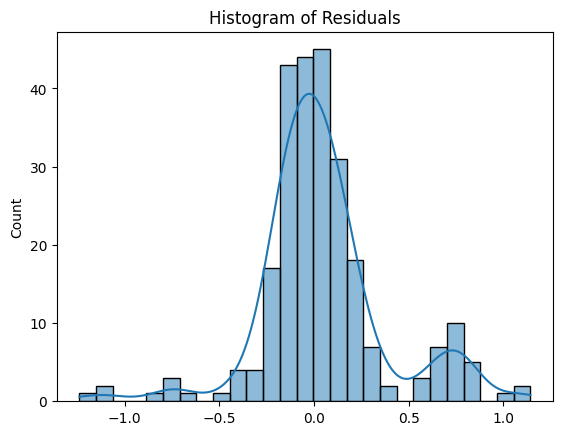

Shapiro-Wilk test statistic: 0.8921014336474457, p-value: 1.985327606899045e-12


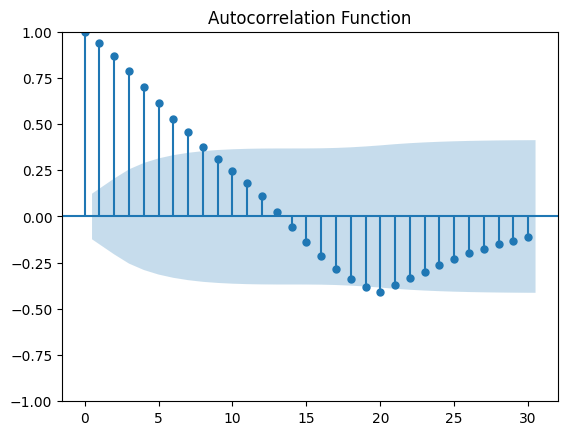

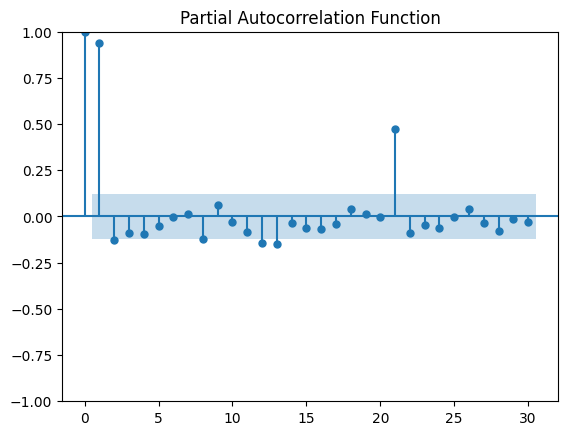

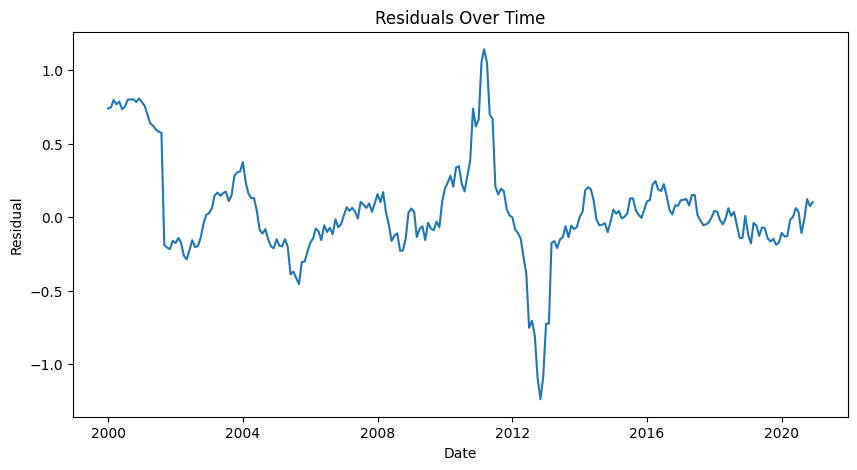

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_residues(resid):
    print("Analyzing residues...")
    # Stationarity test
    adf_result = adfuller(resid)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")

    # Histogram of the residuals
    sns.histplot(resid, kde=True)
    plt.title('Histogram of Residuals')
    plt.show()

    # Normality test
    shapiro_test = shapiro(resid)
    print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

    # ACF and PACF plots
    plot_acf(resid, lags=30)
    plt.title('Autocorrelation Function')
    plt.show()

    plot_pacf(resid, lags=30)
    plt.title('Partial Autocorrelation Function')
    plt.show()

    # Plot of residuals over time
    plt.figure(figsize=(10, 5))
    plt.plot(resid.index, resid)
    plt.title('Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.show()

# Function call at the end of model training
_, _, model_fit, _ = train_model(processed_df)
analyze_residues(model_fit.resid)
